In [14]:
import tensorflow as tf
import sys
sys.path.append('../models/stylegan2')
import dnnlib
import dnnlib.tflib as tflib
from run_generator import generate_images
import pretrained_networks
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pickle as pkl
import gan_helper
import viz
import seaborn as sns

GAN = gan_helper.Generator() # initializes gan
IMAGES_DIR = '../data/annotation-dataset-stylegan2/images'
GENERATING_LATENTS_DIR = '../data/annotation-dataset-stylegan2/data'

Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...


# explore latent space

In [4]:
z = np.random.randn(2000, 512)
w = GAN.z_to_style(z)

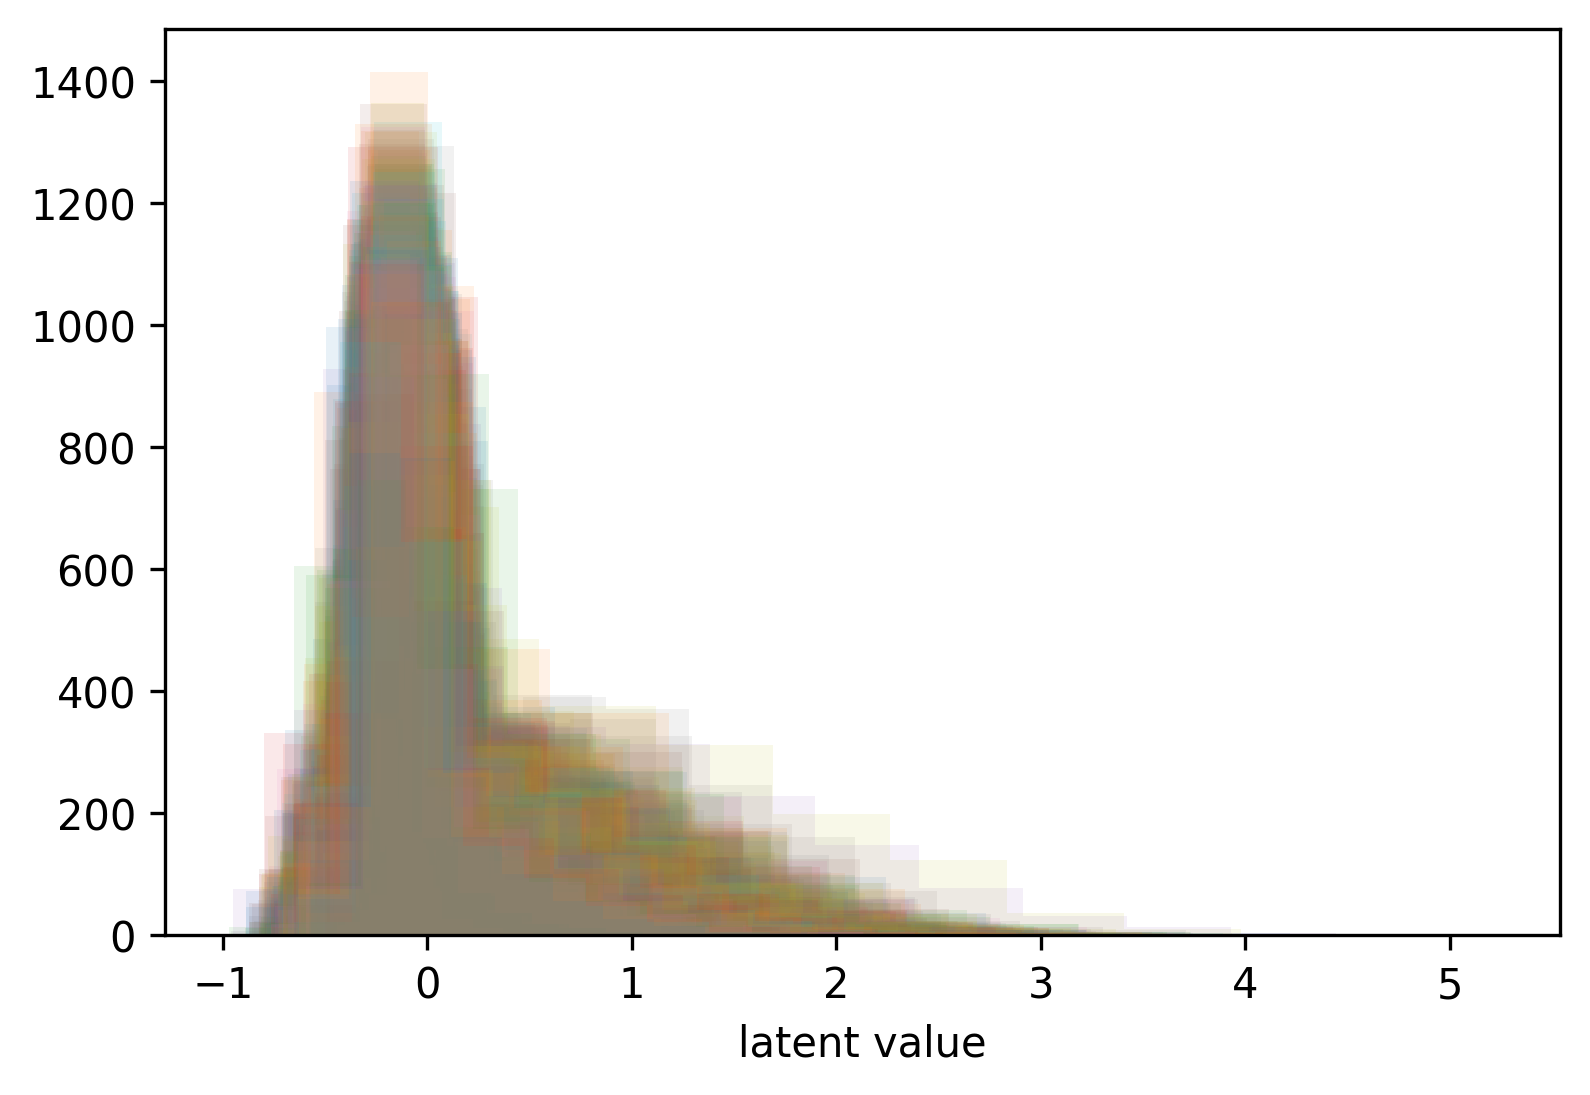

In [5]:
plt.figure(dpi=300)
for i in range(512):
    plt.hist(w[:, 0, i], alpha=0.1)
plt.xlabel('latent value')
plt.show()

In [ ]:
im1 = GAN.gen(z[0])
im2 = GAN.gen_full(w[0:1])
im3 = GAN.gen_full_old(w[0:1])

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


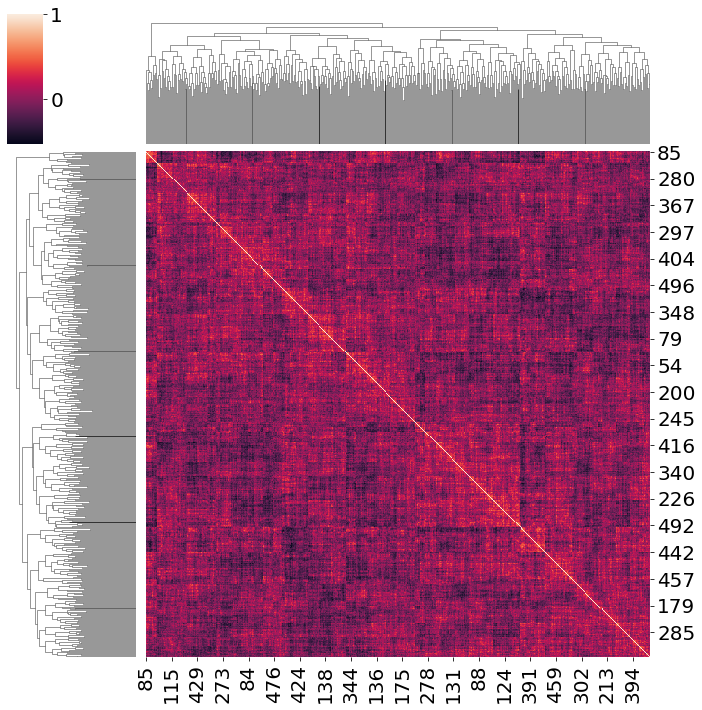

In [17]:
sns.clustermap(np.corrcoef(w[:, 0].transpose()))
plt.show()

# generate a random image

Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


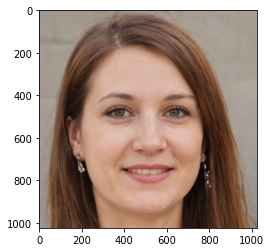

In [2]:
network_pkl = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'
truncation_psi = 0.5


# load the networks
print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False
if truncation_psi is not None:
    Gs_kwargs.truncation_psi = truncation_psi

# generate random z
seed = 0
rnd = np.random.RandomState(seed)
z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]

# generate w
'''
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
w = {var: rnd.randn(*var.shape.as_list()) for var in noise_vars}
tflib.set_vars(w) # [height, width]
'''

# generate imate
images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
# PIL.Image.fromarray(images[0], 'RGB').save(dnnlib.make_run_dir_path('seed%04d.png' % seed))
plt.imshow(images[0])
plt.show()

# recreate image from annotations

(1024, 1024, 3)


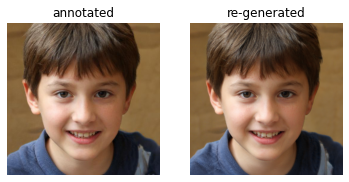

In [3]:
IM_NUM = 1
W = np.load(oj(GENERATING_LATENTS_DIR, 'W.npy'))
Z = np.load(oj(GENERATING_LATENTS_DIR, 'Z.npy'))
z = Z[IM_NUM].reshape(1, -1)
scores = np.load(oj(GENERATING_LATENTS_DIR, 'scores.npy'))

images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
im_gt = PIL.Image.open(oj(IMAGES_DIR, f'{IM_NUM}.jpg'))
print(images[0].shape)
plt.subplot(121)
plt.title('annotated')
plt.imshow(im_gt)
plt.axis('off')
plt.subplot(122)
plt.title('re-generated')
plt.imshow(images[0])
plt.axis('off')
# plt.subplot(133)
# plt.imshow(im_gt - images[0])
plt.show()